In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from heapq import heappush, heappop
from IPython.display import display, clear_output

## TODO: add all possible (empty) initial tris at beginning

[[  0.00000000e+00   1.77600000e+03   3.73400000e+03]
 [  1.00000000e+00   3.87200000e+03   3.27200000e+03]
 [  2.00000000e+00   3.97600000e+03   8.54400000e+03]
 [  3.00000000e+00   7.97000000e+03   4.14800000e+03]
 [  4.00000000e+00   8.00800000e+03   2.29200000e+03]
 [  5.00000000e+00   8.76600000e+03   6.62600000e+03]
 [  6.00000000e+00   9.07200000e+03   2.60600000e+03]
 [  7.00000000e+00   1.01900000e+04   2.55800000e+03]
 [  8.00000000e+00   1.03120000e+04   2.74600000e+03]
 [  9.00000000e+00   1.06880000e+04   3.59800000e+03]
 [  1.00000000e+01   1.07640000e+04   6.52400000e+03]
 [  1.10000000e+01   1.10940000e+04   2.76000000e+03]
 [  1.20000000e+01   1.12140000e+04   3.33000000e+03]
 [  1.30000000e+01   1.13460000e+04   5.45400000e+03]
 [  1.40000000e+01   1.14620000e+04   4.13600000e+03]
 [  1.50000000e+01   1.21640000e+04   6.09200000e+03]
 [  1.60000000e+01   1.25200000e+04   3.22000000e+03]
 [  1.70000000e+01   1.26720000e+04   2.64600000e+03]
 [  1.80000000e+01   1.43380

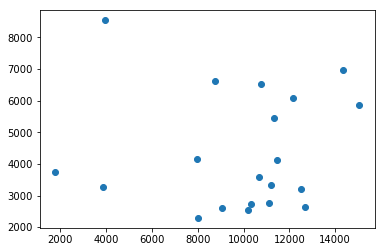

In [2]:
data_pts = np.loadtxt('challenge_instances/data/images/us-night-0000020.instance')
print(data_pts)

plt.scatter(data_pts[:, 1], data_pts[:, 2])
plt.show()

In [3]:
## u,v: both [1x3] with columns [id, x, y]
def perpdot(u, v):
    return u[1]*v[2] - u[2]*v[1]

## function to compute area as integer (loop computes twice the area)
## pts: [nx3] columns are [id, x, y], 
##      auto completes path (loops back to beginning)
def area(pts):
    N = len(pts)
    twicearea = perpdot(pts[0],pts[N-1])
    for i in range(1, N):
        twicearea += perpdot(pts[i],pts[i-1])
    return abs(twicearea / 2)

def area_tri(pt0, pt1, pt2):
    return area(np.array([pt0, pt1, pt2]))

In [4]:
pts_test = np.array([[0, 2],
                     [2, 0],
                     [0, 0]])
print(area(data_pts[:3]))

# sanity check
a = data_pts[0]
b = data_pts[1]
c = data_pts[2]
# a = pts_test[0]
# b = pts_test[1]
# c = pts_test[2]
print( abs((a[1]*(b[2]-c[2]) + b[1]*(c[2]-a[2]) + c[1]*(a[2]-b[2])) / 2) )
print( area_tri(a, b, c) )

5549080.0
5549080.0
5549080.0


In [84]:
def ccw(A,B,C):
    return (C[2]-A[2]) * (B[1]-A[1]) > (B[2]-A[2]) * (C[1]-A[1])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

#  compute whether triangle [C1, C2, D] intersects with any
#      segment in p
def tri_path_intersect(p, C1, C2, D):
    for i in range(len(p)):
        A = p[i]
        B = p[(i+1) % len(p)]
        if A[0] != C1[0] and B[0] != C1[0]:
            if intersect(A, B, C1, D):
                return True
        if A[0] != C2[0] and B[0] != C2[0]:
            if intersect(A, B, C2, D):
                return True
    return False

# pts: original loaded pts [nx3]
# path: ordered list of vertex indices
def plot_poly(pts, path):
    plt_path = np.asarray(path + [path[0]])
    plt.fill(pts[path][:, 1], pts[path][:, 2], '#F7820C8F')
    plt.scatter(pts[:, 1], pts[:, 2])
    plt.show()
    
def rotate_min_first(l):
    min_x = np.inf
    min_i = None
    for i, x in enumerate(l):
        if x < min_x:
            min_x = x
            min_i = i
    
#     print(l, min_i, l[min_i:]+l[:min_i])
    return l[min_i:]+l[:min_i]

def reverse_non_first(l):
    return [l[0]] + l[:0:-1]

In [81]:
## tree structure

class Node:
    def __init__(self, level, area, path):
        self.level = level
        self.area = area
        self.path = path
    
    def __lt__(self, other):
        if self.level != other.level:
            return self.level < other.level
        else:
            return self.area <= other.area

    def __str__(self):
        return "({}, '{:,}', {})".format(self.level, self.area, self.path)
    

In [151]:
## pts: [nx3] columns [id, x, y]
def build_triangulation(pts, show_best_polys=False):
    start_time = time.time()
    N = len(pts)
    P = pts[:, 0].astype(int)
    
    # construct initial smallest tris
    poly_set = set()
    pq = []
    initial_tris = 0
#     start = None
#     start_min_area = np.inf
#     path = []
    for k in range(N):
        best_area = np.inf
        best_path = None
        for i in range(k+1, N):
            for j in range(i+1, N):
                if k != i and k != j and i != j:
                    a = area_tri(pts[k], pts[i], pts[j])
                    if a < best_area:
                        best_area = a
                        best_path = rotate_min_first([P[k], P[i], P[j]])
                        
        if best_path is not None:
            node = Node(-3, best_area, best_path)
            if tuple(best_path) not in poly_set and tuple(reverse_non_first(best_path)) not in poly_set:
                poly_set.add(tuple(best_path))
                heappush(pq, node)
                initial_tris += 1

#     print(len(poly_set), poly_set)
    # explore paths in tree in depth-first manner
    lower_bound = np.inf
    best_poly = None
    progress_best_poly = None
    initial_tris_progress = 0
    while len(pq) > 0:
        parent_node = heappop(pq)
        if parent_node.level == -3:
            initial_tris_progress += 1
            progress_str = '{}/{}  =  {:.2f}%'.format(initial_tris_progress, initial_tris, 100*initial_tris_progress / initial_tris)
#             print(progress_str)
            clear_output(wait=True)
            display(progress_str)
        path = parent_node.path
        free_pts = np.setdiff1d(P, path)  # point ids not yet visited
        
        for i in range(len(path)):  # loop through edges on our poly border
            id1 = path[i]                    # p1 of our new tri
            id2 = path[(i+1) % len(path)]    # p2 of our new tri
            best_area = np.inf
            best_j = -1
            for j in free_pts:  # pick a free point to construct a tri with our edge
                if not tri_path_intersect([x for x in pts[path]], pts[id1], pts[id2], pts[j]):
                    # if new tri doesnt intersect with our poly
                    a = area_tri(pts[id1], pts[id2], pts[j])
                    if a < best_area:
                        best_area = a
                        best_j = j
        
            if best_j > -1:  # only add smallest tris
                cum_a = parent_node.area + best_area
                tmp_path = path.copy()
                tmp_path.insert(i+1, best_j)
                tmp_path = rotate_min_first(tmp_path)
                node = Node(-len(tmp_path), cum_a, tmp_path)

                if len(tmp_path) == N and cum_a < lower_bound:
                    lower_bound = cum_a
                    best_poly = node
                    progress_best_poly = initial_tris_progress
                    if show_best_polys:
                        clear_output(wait=True)
                        print(progress_str)
                        plot_poly(pts, best_poly.path)
                        print(best_poly)
                elif cum_a < lower_bound:
#                 elif cum_a + best_area*(N-len(tmp_path)) < lower_bound:  # guess lower bound (estimate bounds)
                    # check if we have seen this path before
                    if tuple(tmp_path) not in poly_set and tuple(reverse_non_first(tmp_path)) not in poly_set:
                        poly_set.add(tuple(tmp_path))
                        heappush(pq, node)
    
    # print optimal min area poly
    plot_poly(pts, best_poly.path)
    print('done', progress_best_poly,  best_poly)
    
    end_time = time.time()
    diff_time = end_time - start_time
    print('time elapsed: {} mins {:.2f} secs'.format((int)(diff_time // 60), diff_time % 60, 'secs'))

    return np.asarray(path)


# experiments

In [149]:
us_night_0000020 = np.loadtxt('challenge_instances/data/images/us-night-0000020.instance')
uniform_0000030_1 = np.loadtxt('challenge_instances/data/uniform/uniform-0000030-1.instance')
uniform_0000035_1 = np.loadtxt('challenge_instances/data/uniform/uniform-0000035-1.instance')
uniform_0000040_1 = np.loadtxt('challenge_instances/data/uniform/uniform-0000040-1.instance')
uniform_0000045_1 = np.loadtxt('challenge_instances/data/uniform/uniform-0000045-1.instance')
uniform_0000050_1 = np.loadtxt('challenge_instances/data/uniform/uniform-0000050-1.instance')
uniform_0000100_1 = np.loadtxt('challenge_instances/data/uniform/uniform-0000100-1.instance')

'18/18  =  100.00%'

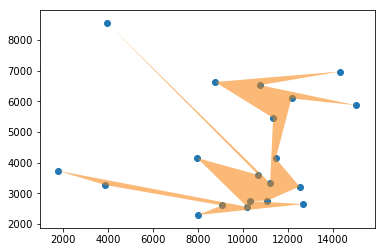

done 6 (-20, '8,544,290.0', [0, 7, 3, 9, 2, 12, 13, 5, 18, 10, 19, 15, 14, 16, 11, 8, 17, 4, 6, 1])
time elapsed: 1 mins 20.45 secs


In [139]:
p = build_triangulation(us_night_0000020, show_best_polys=True)

# A
# show progress + adding smallest tris + prune redundant polys
# progressed to 3/1140 after ~ 1-2mins, with min area of ~8.14 million

# A + C
# show progress + adding smallest tris + estimate bounds + prune redundant polys
# done (-20, '6,799,308.0', [0, 1, 6, 4, 17, 16, 11, 15, 19, 10, 18, 5, 13, 14, 12, 2, 9, 8, 3, 7])
# time elapsed: 4 mins 2.73 secs

# A + B + C
# show progress + adding smallest tris + estimate bounds + prune redundant polys + smallest initial tris
# done 6 (-20, '8,544,290.0', [0, 7, 3, 9, 2, 12, 13, 5, 18, 10, 19, 15, 14, 16, 11, 8, 17, 4, 6, 1])
# time elapsed: 1 mins 20.45 secs

# A + B
# show progress + adding smallest tris + prune redundant polys + smallest initial tris
# done 7 (-20, '7,040,960.0', [0, 1, 6, 8, 9, 3, 14, 13, 2, 5, 18, 10, 15, 12, 19, 7, 16, 11, 17, 4])
# time elapsed: 64 mins 54.47 secs

'28/28  =  100.00%'

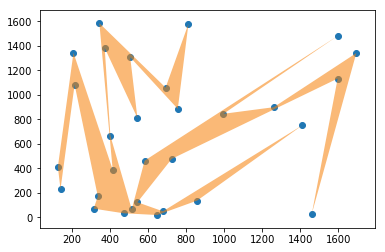

done 4 (-30, '467,992.0', [0, 2, 9, 6, 18, 21, 20, 11, 14, 7, 8, 12, 15, 28, 23, 24, 29, 26, 27, 19, 13, 17, 25, 22, 16, 10, 4, 5, 3, 1])
time elapsed: 9 mins 20.14 secs


In [140]:
p = build_triangulation(uniform_0000030_1, show_best_polys=True)

# show progress + adding smallest tris + estimate bounds + prune redundant polys
# done 4 (-30, '467,992.0', [0, 2, 9, 6, 18, 21, 20, 11, 14, 7, 8, 12, 15, 28, 23, 24, 29, 26, 27, 19, 13, 17, 25, 22, 16, 10, 4, 5, 3, 1])
# time elapsed: 9 mins 20.14 secs

1/33  =  3.03%


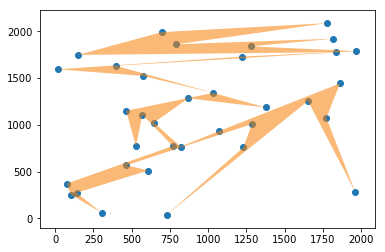

(-35, '641,108.0', [0, 22, 31, 4, 14, 29, 17, 30, 24, 34, 6, 26, 19, 13, 18, 21, 32, 28, 33, 27, 15, 23, 25, 8, 12, 3, 5, 2, 1, 16, 10, 9, 7, 20, 11])
2/33  =  6.06%
3/33  =  9.09%
4/33  =  12.12%
5/33  =  15.15%
6/33  =  18.18%
7/33  =  21.21%
8/33  =  24.24%
9/33  =  27.27%
10/33  =  30.30%
11/33  =  33.33%
12/33  =  36.36%
13/33  =  39.39%
14/33  =  42.42%
15/33  =  45.45%
16/33  =  48.48%
17/33  =  51.52%
18/33  =  54.55%
19/33  =  57.58%
20/33  =  60.61%
21/33  =  63.64%
22/33  =  66.67%
23/33  =  69.70%
24/33  =  72.73%
25/33  =  75.76%
26/33  =  78.79%
27/33  =  81.82%
28/33  =  84.85%
29/33  =  87.88%
30/33  =  90.91%
31/33  =  93.94%
32/33  =  96.97%
33/33  =  100.00%


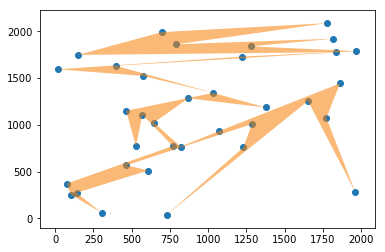

done 1 (-35, '641,108.0', [0, 22, 31, 4, 14, 29, 17, 30, 24, 34, 6, 26, 19, 13, 18, 21, 32, 28, 33, 27, 15, 23, 25, 8, 12, 3, 5, 2, 1, 16, 10, 9, 7, 20, 11])
time elapsed: 6 mins 26.37 secs


In [143]:
p = build_triangulation(uniform_0000035_1, show_best_polys=True)


1/38  =  2.63%


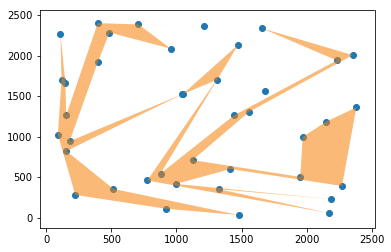

(-40, '1,143,298.0', [0, 2, 1, 3, 4, 9, 21, 12, 16, 10, 8, 6, 19, 26, 14, 30, 25, 36, 29, 38, 28, 20, 31, 32, 33, 39, 37, 24, 17, 35, 23, 34, 13, 22, 18, 5, 11, 27, 15, 7])
2/38  =  5.26%
3/38  =  7.89%
4/38  =  10.53%
5/38  =  13.16%
6/38  =  15.79%
7/38  =  18.42%
8/38  =  21.05%
9/38  =  23.68%
10/38  =  26.32%
11/38  =  28.95%
12/38  =  31.58%
13/38  =  34.21%
14/38  =  36.84%
15/38  =  39.47%
16/38  =  42.11%
17/38  =  44.74%
18/38  =  47.37%
19/38  =  50.00%
20/38  =  52.63%
21/38  =  55.26%
22/38  =  57.89%
23/38  =  60.53%
24/38  =  63.16%
25/38  =  65.79%
26/38  =  68.42%
27/38  =  71.05%
28/38  =  73.68%
29/38  =  76.32%
30/38  =  78.95%
31/38  =  81.58%
32/38  =  84.21%
33/38  =  86.84%
34/38  =  89.47%
35/38  =  92.11%
36/38  =  94.74%
37/38  =  97.37%
38/38  =  100.00%


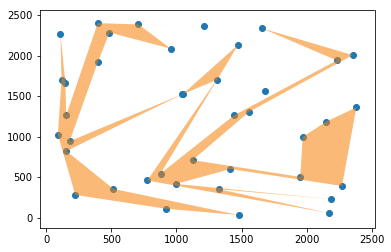

done 1 (-40, '1,143,298.0', [0, 2, 1, 3, 4, 9, 21, 12, 16, 10, 8, 6, 19, 26, 14, 30, 25, 36, 29, 38, 28, 20, 31, 32, 33, 39, 37, 24, 17, 35, 23, 34, 13, 22, 18, 5, 11, 27, 15, 7])
time elapsed: 11 mins 7.58 secs


In [146]:
p = build_triangulation(uniform_0000040_1, show_best_polys=True)

1/43  =  2.33%


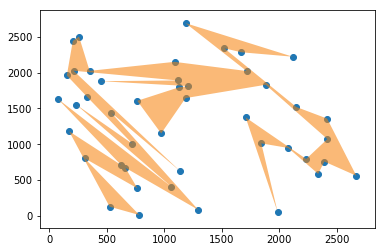

(-45, '1,509,976.0', [0, 13, 2, 11, 18, 7, 17, 14, 28, 12, 24, 4, 22, 10, 27, 23, 16, 19, 25, 34, 43, 39, 31, 35, 33, 36, 40, 41, 44, 42, 38, 29, 30, 37, 26, 32, 21, 9, 6, 3, 1, 8, 15, 5, 20])


KeyboardInterrupt: 

In [147]:
p = build_triangulation(uniform_0000045_1, show_best_polys=True)

In [ ]:
p = build_triangulation(uniform_0000050_1, show_best_polys=True)

1/98  =  1.02%


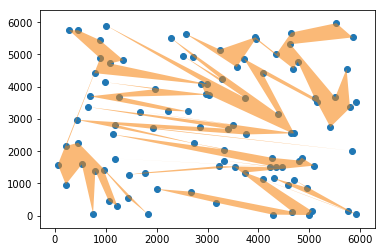

(-100, '8,466,926.0', [0, 1, 7, 10, 12, 18, 23, 15, 26, 30, 6, 2, 11, 43, 44, 16, 32, 9, 34, 38, 24, 46, 75, 28, 54, 8, 53, 42, 4, 52, 20, 69, 51, 65, 22, 72, 48, 29, 27, 55, 77, 39, 33, 47, 67, 85, 86, 64, 99, 79, 84, 68, 73, 94, 58, 87, 83, 82, 66, 41, 21, 96, 31, 60, 80, 63, 89, 90, 98, 95, 93, 91, 74, 97, 92, 76, 70, 61, 49, 37, 56, 62, 78, 81, 88, 57, 71, 35, 40, 50, 36, 59, 17, 45, 19, 25, 13, 5, 3, 14])


KeyboardInterrupt: 

In [150]:
p = build_triangulation(uniform_0000100_1, show_best_polys=True)

# experiments n=10

In [9]:
euro_night_0000010 = np.loadtxt('challenge_instances/data/images/euro-night-0000010.instance')
london_0000010 = np.loadtxt('challenge_instances/data/images/london-0000010.instance')
stars_0000010 = np.loadtxt('challenge_instances/data/images/stars-0000010.instance')
us_night_0000010 = np.loadtxt('challenge_instances/data/images/us-night-0000010.instance')


uniform_0000010_1 = np.loadtxt('challenge_instances/data/uniform/uniform-0000010-1.instance')
uniform_0000010_2 = np.loadtxt('challenge_instances/data/uniform/uniform-0000010-2.instance')

### 1/6

'8/8  =  100.00%'

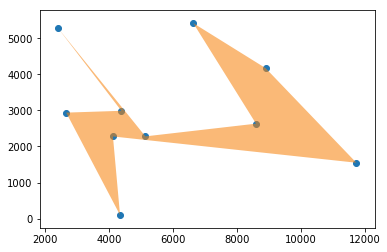

done 1 (-10, '9,954,272.0', [0, 4, 1, 3, 2, 9, 8, 6, 7, 5])
time elapsed: 0 mins 0.90 secs


In [152]:
p = build_triangulation(euro_night_0000010)

# 1 min ..
# 4 mins 38.45 secs

# only adding smallest possible tris
# done (-10, '9,954,272.0', [0, 4, 1, 3, 2, 9, 8, 6, 7, 5])
# time elapsed: 0 mins 26.37 secs

# show progress + adding smallest tris + estimate bounds + prune redundant polys
# done (-10, '9,954,272.0', [0, 4, 1, 3, 2, 9, 8, 6, 7, 5])
# time elapsed: 0 mins 0.82 secs

### 2/6

'8/8  =  100.00%'

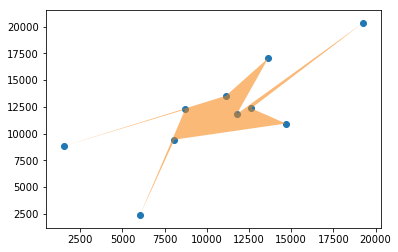

done 1 (-10, '19,207,298.0', [0, 4, 7, 5, 9, 6, 8, 2, 1, 3])
time elapsed: 0 mins 0.65 secs


In [131]:
p = build_triangulation(london_0000010)

# done (-10, '19,207,298.0', [2, 1, 3, 0, 4, 7, 5, 9, 6, 8])
# time elapsed: 3 mins 41.61 secs


# show progress + adding smallest tris
# done (-10, '19,207,298.0', [2, 1, 3, 0, 4, 7, 5, 9, 6, 8])
# time elapsed: 0 mins 26.56 secs

# show progress + adding smallest tris + estimate bounds
# done (-10, '19,207,298.0', [2, 1, 3, 0, 4, 7, 5, 9, 6, 8])
# time elapsed: 0 mins 2.12 secs

# show progress + adding smallest tris + prune redundant polys
# done (-10, '19,207,298.0', [0, 4, 7, 5, 9, 6, 8, 2, 1, 3])
# time elapsed: 0 mins 1.79 secs

# show progress + adding smallest tris + estimate bounds + prune redundant polys
# done 1 (-10, '19,207,298.0', [0, 4, 7, 5, 9, 6, 8, 2, 1, 3])
# time elapsed: 0 mins 0.82 secs

### 3/6

'8/8  =  100.00%'

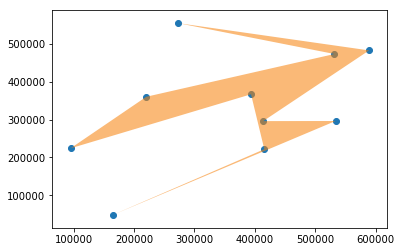

done 1 (-10, '40,264,246,222.0', [0, 2, 7, 3, 9, 5, 8, 1, 6, 4])
time elapsed: 0 mins 0.54 secs


In [132]:
p = build_triangulation(stars_0000010)

# done (-9, '40,264,246,222.0', [5, 9, 3, 7, 2, 0, 4, 6, 1, 8])
# time elapsed: 1 mins 26.61832022666931 secs

# show progress + adding smallest tris
# done (-10, '40,264,246,222.0', [4, 0, 2, 7, 3, 9, 5, 8, 1, 6])
# time elapsed: 0 mins 21.48 secs

# show progress + adding smallest tris + estimate bounds
# done (-10, '40,264,246,222.0', [4, 0, 2, 7, 3, 9, 5, 8, 1, 6])
# time elapsed: 0 mins 1.35 secs

# show progress + adding smallest tris + prune redundant polys
# done (-10, '40,264,246,222.0', [0, 2, 7, 3, 9, 5, 8, 1, 6, 4])
# time elapsed: 0 mins 1.61 secs

# show progress + adding smallest tris + estimate bounds + prune redundant polys
# done (-10, '40,264,246,222.0', [0, 2, 7, 3, 9, 5, 8, 1, 6, 4])
# time elapsed: 0 mins 0.67 secs

### 4/6

'8/8  =  100.00%'

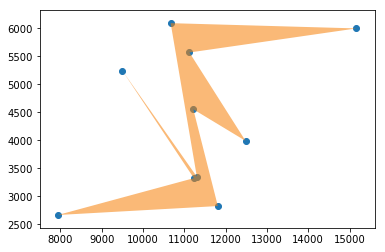

done 1 (-10, '3,650,560.0', [0, 5, 1, 6, 2, 9, 3, 8, 4, 7])
time elapsed: 0 mins 0.50 secs


In [133]:
p = build_triangulation(us_night_0000010)

# done (-9, '3,650,560.0', [5, 1, 6, 2, 9, 3, 8, 4, 7, 0])
# time elapsed: 3 mins 40.07 secs

# show progress + adding smallest tris
# done (-10, '3,650,560.0', [2, 9, 3, 8, 4, 7, 0, 5, 1, 6])
# time elapsed: 0 mins 35.88 secs

# show progress + adding smallest tris + estimate bounds
# done (-10, '3,650,560.0', [2, 9, 3, 8, 4, 7, 0, 5, 1, 6])
# time elapsed: 0 mins 3.20 secs

# show progress + adding smallest tris + prune redundant polys
# done (-10, '3,650,560.0', [0, 5, 1, 6, 2, 9, 3, 8, 4, 7])
# time elapsed: 0 mins 1.59 secs

# show progress + adding smallest tris + estimate bounds + prune redundant polys
# done (-10, '3,650,560.0', [0, 5, 1, 6, 2, 9, 3, 8, 4, 7])
# time elapsed: 0 mins 0.88 secs

### 5/6

'8/8  =  100.00%'

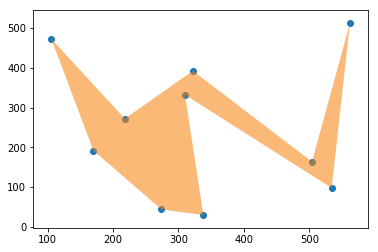

done 5 (-10, '58,872.0', [0, 2, 5, 7, 9, 8, 4, 6, 3, 1])
time elapsed: 0 mins 0.49 secs


In [134]:
p = build_triangulation(uniform_0000010_1)

# done (-9, '58,872.0', [1, 0, 2, 5, 7, 9, 8, 4, 6, 3])
# time elapsed: 1 mins 23.47 secs

# show progress + adding smallest tris bugged?
# done (-10, '61,260.0', [4, 2, 6, 3, 1, 0, 5, 7, 9, 8])
# time elapsed: 0 mins 5.80 secs
# plot_poly(uniform_0000010_1, [4, 2, 6, 3, 1, 0, 5, 7, 9, 8])  # shows bugged version terminating too early

# show progress + adding smallest tris
# done (-10, '58,872.0', [5, 7, 9, 8, 4, 6, 3, 1, 0, 2])
# time elapsed: 0 mins 18.98 secs

# show progress + adding smallest tris + estimate bounds
# done (-10, '58,872.0', [5, 7, 9, 8, 4, 6, 3, 1, 0, 2])
# time elapsed: 0 mins 1.34 secs

# show progress + adding smallest tris + prune redundant polys
# done (-10, '58,872.0', [0, 2, 5, 7, 9, 8, 4, 6, 3, 1])
# time elapsed: 0 mins 1.79 secs

# show progress + adding smallest tris + estimate bounds + prune redundant polys
# done (-10, '58,872.0', [0, 2, 5, 7, 9, 8, 4, 6, 3, 1])
# time elapsed: 0 mins 0.75 secs

### 6/6

'8/8  =  100.00%'

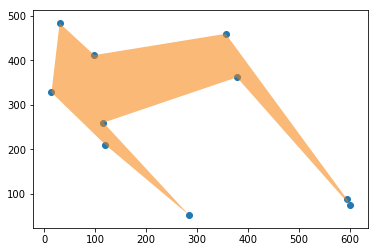

done 1 (-10, '61,478.0', [0, 1, 2, 6, 8, 9, 7, 3, 5, 4])
time elapsed: 0 mins 0.28 secs


In [135]:
p = build_triangulation(uniform_0000010_2)

# done (-9, '51,568.0', [3, 2, 7, 9, 8, 6, 1, 0, 4, 5])
# time elapsed: 0 mins 38.55288004875183 secs

# done (-10, '51,568.0', [2, 3, 5, 4, 0, 1, 6, 8, 9, 7])
# time elapsed: 1 mins 10.56 secs

# show progress + adding smallest tris
# done (-10, '51,568.0', [1, 0, 4, 5, 3, 2, 7, 9, 8, 6])
# time elapsed: 0 mins 10.28 secs

# show progress + adding smallest tris + estimate bounds
# done (-10, '51,568.0', [1, 0, 4, 5, 3, 2, 7, 9, 8, 6])
# time elapsed: 0 mins 2.03 secs

# show progress + adding smallest tris + prune redundant polys
# done (-10, '51,568.0', [0, 4, 5, 3, 2, 7, 9, 8, 6, 1])
# time elapsed: 0 mins 1.17 secs

# show progress + adding smallest tris + estimate bounds + prune redundant polys
# done (-10, '51,568.0', [0, 4, 5, 3, 2, 7, 9, 8, 6, 1])
# time elapsed: 0 mins 0.64 secs

# show progress + adding smallest tris + estimate bounds + prune redundant polys + smallest initial tris

# show progress + adding smallest tris + prune redundant polys + smallest initial tris
# done 1 (-10, '61,478.0', [0, 1, 2, 6, 8, 9, 7, 3, 5, 4])
# time elapsed: 0 mins 0.27 secs

# experiments n=15

In [153]:
euro_night_0000015 = np.loadtxt('challenge_instances/data/images/euro-night-0000015.instance')
london_0000015 = np.loadtxt('challenge_instances/data/images/london-0000015.instance')
stars_0000015 = np.loadtxt('challenge_instances/data/images/stars-0000015.instance')
us_night_0000015 = np.loadtxt('challenge_instances/data/images/us-night-0000015.instance')


uniform_0000015_1 = np.loadtxt('challenge_instances/data/uniform/uniform-0000015-1.instance')
uniform_0000015_2 = np.loadtxt('challenge_instances/data/uniform/uniform-0000015-2.instance')

'13/13  =  100.00%'

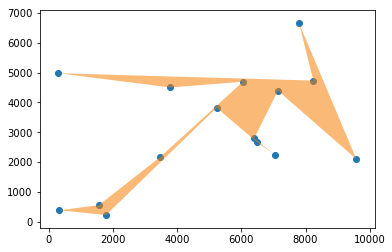

done 1 (-15, '7,107,334.0', [0, 5, 7, 4, 2, 1, 3, 6, 9, 10, 8, 11, 14, 12, 13])
time elapsed: 1 mins 9.56 secs


In [154]:
p = build_triangulation(euro_night_0000015)

# show progress + adding smallest tris + estimate bounds?
# done (-15, '7,661,692.0', [4, 3, 1, 2, 7, 5, 0, 13, 12, 14, 11, 6, 10, 9, 8])
# time elapsed: 5 mins 17.63 secs
# plot_poly(euro_night_0000015, [4, 3, 1, 2, 7, 5, 0, 13, 12, 14, 11, 6, 10, 9, 8])

# A
# show progress + adding smallest tris + prune redundant polys
# done (-15, '7,107,334.0', [0, 5, 7, 4, 2, 1, 3, 6, 9, 10, 8, 11, 14, 12, 13])
# time elapsed: 2 mins 55.48 secs

# A + C
# show progress + adding smallest tris + estimate bounds + prune redundant polys
# done (-15, '7,661,692.0', [0, 13, 12, 14, 11, 6, 10, 9, 8, 4, 3, 1, 2, 7, 5])
# time elapsed: 0 mins 10.09 secs

# A + B + C
# show progress + adding smallest tris + estimate bounds + prune redundant polys + smallest initial tris
# done 1 (-15, '8,752,112.0', [0, 6, 11, 1, 3, 9, 10, 14, 8, 2, 4, 13, 7, 12, 5])
# time elapsed: 0 mins 1.56 secs

# A + B
# show progress + adding smallest tris + prune redundant polys + smallest initial tris
# done 1 (-15, '7,107,334.0', [0, 5, 7, 4, 2, 1, 3, 6, 9, 10, 8, 11, 14, 12, 13])
# time elapsed: 0 mins 38.96 secs

In [ ]:

#                     if a < i_min_area:  # update smallest tri for this edge
#                         i_min_area = a
#                         id3_min_area = j       # p3 of our new tri

#             if i_min_area < min_area:  # updates smallest tri among all edges
#                 min_area = i_min_area
#                 min_i = i
#                 min_j = id3_min_area
        
#         # add smallest tri to path
#         if min_j != -1:
# #             path.insert(min_i+1, pts[min_j])
#             path.insert(min_i+1, min_j)
# #             P_path = np.array(path)[:, 0].astype(int)  # point ids in path
#             P_path = path
#         else:
#             print(tri_path_intersect(path, pts[0], pts[9], pts[6]))
#             plt_path = np.asarray(path + [path[0]])
#             plt.plot(plt_path[:, 1], plt_path[:, 2])
#             plt.plot(data_pts[[0, 6, 9], 1], data_pts[[0, 6, 9], 2])
#             plt.scatter(data_pts[:, 1], data_pts[:, 2])
#             plt.show()
#             raise Exception('couldnt find tri to add')